In [1]:
import spacetime as st
import numpy as np
import perfplot
import matplotlib.pyplot as plt
import functools

# Combine multiple benchmark data objects with each other
def PerfplotData_append(self, other):
    assert np.array_equal(self.n_range, other.n_range)
    n_range = self.n_range
    timings_s = np.concatenate([self.timings_s, other.timings_s])
    flop = self.flop
    labels = self.labels + other.labels
    xlabel = self.xlabel
    title = self.title
    return perfplot._main.PerfplotData(
        n_range,
        timings_s,
        flop,
        labels,
        xlabel,
        title
    )

perfplot._main.PerfplotData.__add__ = PerfplotData_append

# Function to run multiple different benchmarks with different
# setup functions and combine results. This is needed because
# perfplot does not allow you to specify different setup functions
# for different kernels.
def bench_multiple(m_list, n_list, setup, kernels, labels, xlabel):
    benchmarks = []
    
    for m in m_list:
        benchmarks.append(perfplot.bench(
            n_range=n_list,
            setup=setup(m),
            kernels=kernels(m),
            labels=labels(m),
            xlabel=xlabel,
            equality_check=None,
            show_progress=False
        ))
    return functools.reduce(PerfplotData_append, benchmarks)

In [2]:
nevent_list = [1, 2, 10, 20, 50, 100, 1000, 10_000, 100_000]
ndim_list = [2, 4, 10]

res1 = bench_multiple(
    ndim_list,
    nevent_list,
    setup=lambda ndim: lambda nevent: (
        np.random.rand(nevent, ndim),
        np.random.rand(ndim - 1) * (1/(ndim-1)**0.5)
    ),
    kernels=lambda ndim: [
        lambda a, b: (st.boost(a, b, _old=True)),
    ],
    labels=lambda ndim: [f'boost {ndim}-D'],
    xlabel='num events'
)

res2 = bench_multiple(
    ndim_list,
    nevent_list,
    setup=lambda ndim: lambda nevent: (
        np.random.rand(nevent, ndim),
        np.random.rand(ndim - 1) * (1/(ndim-1)**0.5)
    ),
    kernels=lambda ndim: [
        lambda a, b: (st.boost(a, b)),
    ],
    labels=lambda ndim: [f'boost improved {ndim}-D'],
    xlabel='num events'
)

Output()

Output()

Output()

Output()

Output()

Output()

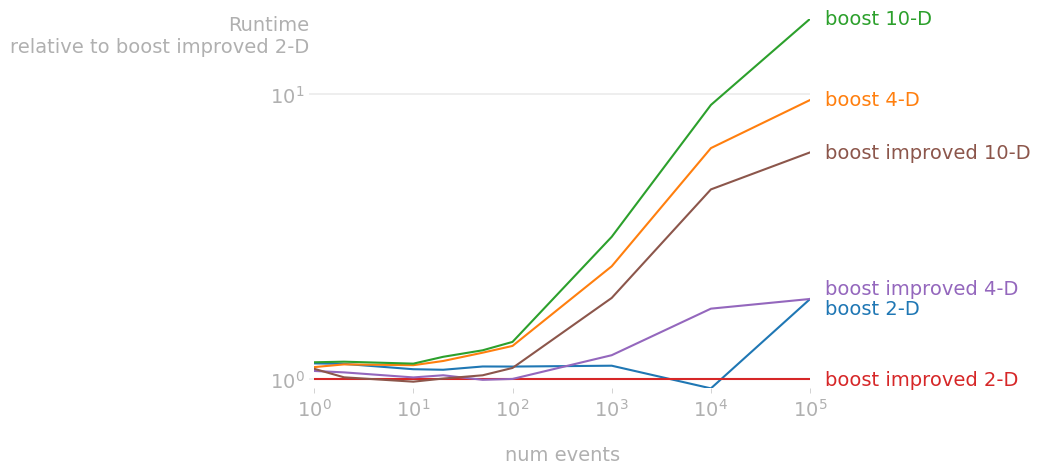

In [3]:
(res1 + res2).plot(logy=True, logx=True, relative_to=3)

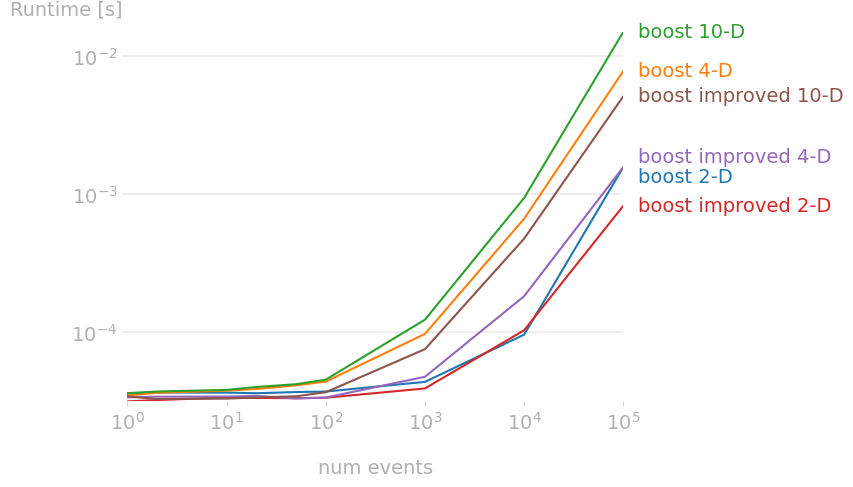

In [6]:
(res1 + res2).plot(logx=True, logy=True)